# **Import Library dan Data**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, when, udf, length, split
from pyspark.sql.types import IntegerType, DoubleType, ArrayType, StringType
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()

filename = "allReview.csv"
df = spark.read.csv(filename, header=True, inferSchema=True, encoding="latin1")
df.show()

+--------------------+--------------------+------+--------------------+
|          Hotel_name|                name|rating|              review|
+--------------------+--------------------+------+--------------------+
|ASTON Bellevue Ra...|     Felicia Gunardi|   3.0|We tried this hot...|
|ASTON Bellevue Ra...|               M Ang|   2.0|Hotel is south ar...|
|Staff is nice But...|                NULL|  NULL|                NULL|
|The bed is confor...|                NULL|  NULL|                NULL|
|No safe in the ro...|                NULL|  NULL|                NULL|
|Breakfast is simp...| no coffee machin...|  NULL|                NULL|
|ASTON Bellevue Ra...|       Diandra Harun|   1.0|The worst service...|
|ASTON Bellevue Ra...|     Trip.com Member|   1.0|This is the WORST...|
|ASTON Bellevue Ra...|        Bella Salsha|   5.0|I was booked for ...|
|ASTON Bellevue Ra...|         FandiStevee|   1.0|I went to the spa...|
|ASTON Bellevue Ra...|                Tabi|   1.0|They didnt cha

In [ ]:
df = df.select("rating", "review")
df = df.dropna(subset=["rating", "review"])

df.show()

+--------------------+--------------------+
|              rating|              review|
+--------------------+--------------------+
|                 3.0|We tried this hot...|
|                 2.0|Hotel is south ar...|
|                 1.0|The worst service...|
|                 1.0|This is the WORST...|
|                 5.0|I was booked for ...|
|                 1.0|I went to the spa...|
|                 1.0|They didnt change...|
|                 4.0|Room was good. Fo...|
|                 2.0|the staff are not...|
|                 3.0|Came here for a b...|
| this hotel did n...| the pool here is...|
|                 1.0|"Here I am again ...|
|                 5.0|Best food in the ...|
|                 3.0|Good location, bu...|
|                 1.0|Very bad experience.|
|                 5.0|What a perfect pl...|
|                 5.0|It was a good hot...|
|                 2.0|Requested for hig...|
|                 5.0|Thank you Aston H...|
|                 5.0|The room s

# **Preprocessing Data**


<h2>Cleaning the text</h2>

In [ ]:
df = df.withColumn("cleaned_text", lower(regexp_replace(col("review"), "[^a-zA-Z\s]", "")))

df = df.withColumn("label",
                   when((col("rating") >= 1.0) & (col("rating") <= 3.0), 0)
                   .when((col("rating") > 3.0) & (col("rating") <= 5.0), 1)
                   .otherwise(None))
df = df.dropna(subset=["label"])
df.show()

+------+--------------------+--------------------+-----+
|rating|              review|        cleaned_text|label|
+------+--------------------+--------------------+-----+
|   3.0|We tried this hot...|we tried this hot...|    0|
|   2.0|Hotel is south ar...|hotel is south area |    0|
|   1.0|The worst service...|the worst service...|    0|
|   1.0|This is the WORST...|this is the worst...|    0|
|   5.0|I was booked for ...|i was booked for ...|    1|
|   1.0|I went to the spa...|i went to the spa...|    0|
|   1.0|They didnt change...|they didnt change...|    0|
|   4.0|Room was good. Fo...|room was good foo...|    1|
|   2.0|the staff are not...|the staff are not...|    0|
|   3.0|Came here for a b...|came here for a b...|    0|
|   1.0|"Here I am again ...|here i am again t...|    0|
|   5.0|Best food in the ...|best food in the ...|    1|
|   3.0|Good location, bu...|good location but...|    0|
|   1.0|Very bad experience.| very bad experience|    0|
|   5.0|What a perfect pl...|wh

<h2>Adding additional features - length of, and percentage of punctuations in the text</h2>

In [ ]:
def review_length(text):
    return len(text) - text.count(" ")

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count / (len(text) - text.count(" ")), 3) * 100

# Register UDF
review_length_udf = udf(review_length, IntegerType())
count_punct_udf = udf(count_punct, DoubleType())

df = df.withColumn("Review_len", review_length_udf(col("review")))
df = df.withColumn("punct", count_punct_udf(col("review")))

df.show()

+------+--------------------+--------------------+-----+----------+------------------+
|rating|              review|        cleaned_text|label|Review_len|             punct|
+------+--------------------+--------------------+-----+----------+------------------+
|   3.0|We tried this hot...|we tried this hot...|    0|       587|               2.4|
|   2.0|Hotel is south ar...|hotel is south area |    0|        17|5.8999999999999995|
|   1.0|The worst service...|the worst service...|    0|       315|               1.3|
|   1.0|This is the WORST...|this is the worst...|    0|       373|               2.4|
|   5.0|I was booked for ...|i was booked for ...|    1|       248|               2.4|
|   1.0|I went to the spa...|i went to the spa...|    0|       204|               2.0|
|   1.0|They didnt change...|they didnt change...|    0|        40|               0.0|
|   4.0|Room was good. Fo...|room was good foo...|    1|        94|               5.3|
|   2.0|the staff are not...|the staff are 

<h2>Tokenization</h2>

In [ ]:
def tokenize_text(text):
    return text.split()
tokenize_text_udf = udf(tokenize_text, ArrayType(StringType()))

df = df.withColumn("tokens", tokenize_text_udf(col("cleaned_text")))

df.show()

+------+--------------------+--------------------+-----+----------+------------------+--------------------+
|rating|              review|        cleaned_text|label|Review_len|             punct|              tokens|
+------+--------------------+--------------------+-----+----------+------------------+--------------------+
|   3.0|We tried this hot...|we tried this hot...|    0|       587|               2.4|[we, tried, this,...|
|   2.0|Hotel is south ar...|hotel is south area |    0|        17|5.8999999999999995|[hotel, is, south...|
|   1.0|The worst service...|the worst service...|    0|       315|               1.3|[the, worst, serv...|
|   1.0|This is the WORST...|this is the worst...|    0|       373|               2.4|[this, is, the, w...|
|   5.0|I was booked for ...|i was booked for ...|    1|       248|               2.4|[i, was, booked, ...|
|   1.0|I went to the spa...|i went to the spa...|    0|       204|               2.0|[i, went, to, the...|
|   1.0|They didnt change...

<h2>Lemmatization and Removing Stopwords</h2>

In [ ]:
nltk.download('stopwords')
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

# Fungsi untuk lemmatisasi teks dan menghapus stopwords
def lemmatize_text(token_list):
    return " ".join([lemmatizer.lemmatize(token) for token in token_list if token not in set(all_stopwords)])

lemmatize_text_udf = udf(lemmatize_text, StringType())

lemmatizer = WordNetLemmatizer()

df = df.withColumn("lemmatized_review", lemmatize_text_udf(col("tokens")))

df.show()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


+------+--------------------+--------------------+-----+----------+------------------+--------------------+--------------------+
|rating|              review|        cleaned_text|label|Review_len|             punct|              tokens|   lemmatized_review|
+------+--------------------+--------------------+-----+----------+------------------+--------------------+--------------------+
|   3.0|We tried this hot...|we tried this hot...|    0|       587|               2.4|[we, tried, this,...|tried hotel cause...|
|   2.0|Hotel is south ar...|hotel is south area |    0|        17|5.8999999999999995|[hotel, is, south...|    hotel south area|
|   1.0|The worst service...|the worst service...|    0|       315|               1.3|[the, worst, serv...|worst service exp...|
|   1.0|This is the WORST...|this is the worst...|    0|       373|               2.4|[this, is, the, w...|worst hotel ever ...|
|   5.0|I was booked for ...|i was booked for ...|    1|       248|               2.4|[i, was, bo

# **EDA**

In [ ]:
pandas_df = df.toPandas()
# Menghentikan SparkSession
spark.stop()

pandas_df['rating'] = pandas_df['rating'].astype(float)

print(f"Input data has {len(pandas_df)} rows and {len(pandas_df.columns)} columns")

rating_ranges = [(1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0)]
for start, end in rating_ranges:
    print(f"Ratings from {start} to {end} = {len(pandas_df[(pandas_df['rating'] >= start) & (pandas_df['rating'] < end)])} rows")

print(f"Ratings of 5.0 = {len(pandas_df[pandas_df['rating'] == 5.0])} rows")

Input data has 510 rows and 8 columns
Ratings from 1.0 to 2.0 = 20 rows
Ratings from 2.0 to 3.0 = 15 rows
Ratings from 3.0 to 4.0 = 45 rows
Ratings from 4.0 to 5.0 = 110 rows
Ratings of 5.0 = 320 rows


Number of null in rating: 0
Number of null in review: 0


<Axes: xlabel='rating', ylabel='count'>

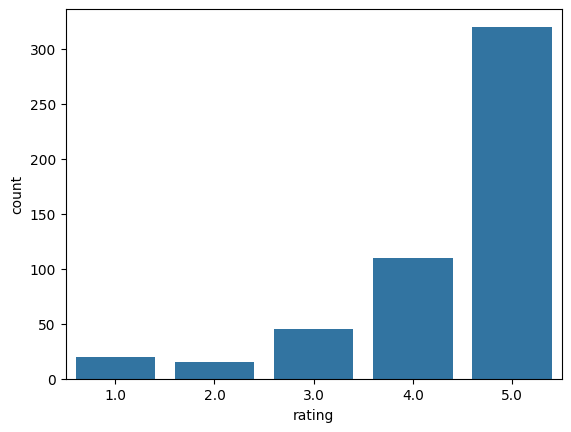

In [ ]:
import seaborn as sns

num_null_rating = pandas_df['rating'].isnull().sum()
num_null_review = pandas_df['review'].isnull().sum()
print(f"Number of null in rating: {num_null_rating}")
print(f"Number of null in review: {num_null_review}")

sns.countplot(x='rating', data=pandas_df)

# **Visualizing Word Clouds**

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Additional script for separating negative and positive reviews
df_negative = pandas_df[(pandas_df['rating'] >= 1.0) & (pandas_df['rating'] < 4.0)]
df_positive = pandas_df[(pandas_df['rating'] >= 4.0) & (pandas_df['rating'] <= 5.0)]

# Convert to list
negative_list = df_negative['lemmatized_review'].tolist()
positive_list = df_positive['lemmatized_review'].tolist()

filtered_negative = "".join(str(negative_list))
filtered_negative = filtered_negative.lower()

filtered_positive = "".join(str(positive_list))
filtered_positive = filtered_positive.lower()

<h3><b>Word Cloud</b>: Positive Reviews</h3>

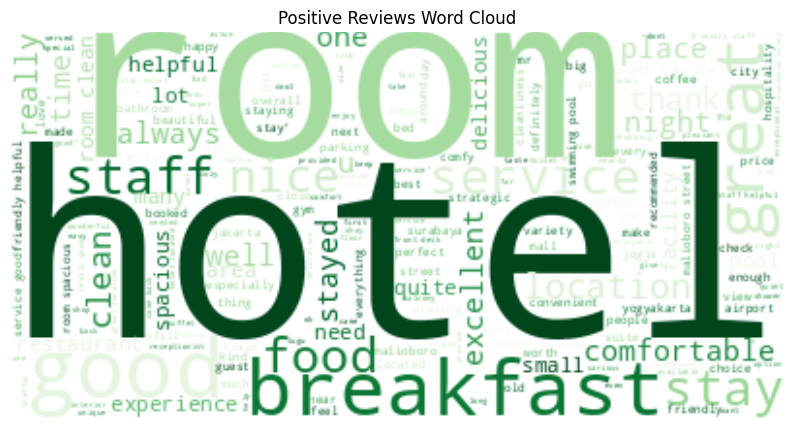

In [ ]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Greens").generate(filtered_positive)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Positive Reviews Word Cloud")
plt.show()

<h3><b>Word Cloud</b>: Negative Reviews</h3>

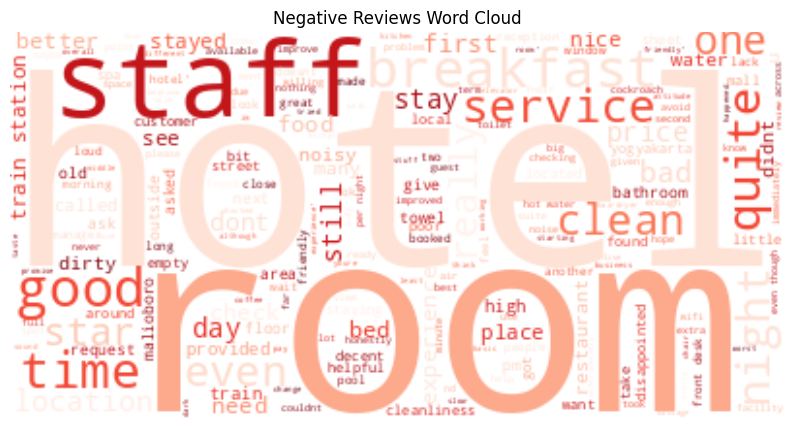

In [ ]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Reds").generate(filtered_negative)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Negative Reviews Word Cloud")
plt.show()

# **Feature Extraction from Text**

*   Vectorizer : TF-IDF

In [ ]:
# Memisahkan fitur dan label
X = pandas_df[['lemmatized_review', 'Review_len', 'punct']]
y = pandas_df['label']

print(X.shape)
print(y.shape)

(510, 3)
(510,)


In [ ]:
# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(357, 3)
(153, 3)
(357,)
(153,)


In [ ]:
# Menggunakan TfidfVectorizer untuk transformasi teks
tfidf = TfidfVectorizer(max_df=0.5, min_df=2)
tfidf_train = tfidf.fit_transform(X_train['lemmatized_review'])
tfidf_test = tfidf.transform(X_test['lemmatized_review'])

# Menggabungkan hasil transformasi tf-idf dengan fitur numerik lainnya
X_train_vect = pd.concat([X_train[['Review_len', 'punct']].reset_index(drop=True),
                          pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['Review_len', 'punct']].reset_index(drop=True),
                         pd.DataFrame(tfidf_test.toarray())], axis=1)

# Menampilkan hasil gabungan fitur
print(X_train_vect.head())

   Review_len  punct    0    1    2    3    4    5    6    7  ...  942  943  \
0          81    2.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1          44   11.4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2        1192    4.7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3          68    4.4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4         204    2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

   944  945       946  947       948  949       950  951  
0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  
1  0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  
2  0.0  0.0  0.101072  0.0  0.088955  0.0  0.086261  0.0  
3  0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  
4  0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  

[5 rows x 954 columns]


# **Predictions**








---

*   <u>Vectorizer</u>: TF-IDF
*   <u>Algoritma</u>: Extra Trees Classifier

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 10)
# from sklearn.ensemble import ExtraTreesClassifier
# classifier = ExtraTreesClassifier(n_estimators=150, random_state=50)

classifier.fit(tfidf_train, y_train)
classifier.score(tfidf_test, y_test)

0.8431372549019608

In [ ]:
data = ["the hotel is really enjoy", "Good", "I hate the service, it's really bad", "The nurse is so kind"]
vect = tfidf.transform(data).toarray()

my_pred = classifier.predict(vect)
print(my_pred)

[1 1 0 1]








---

*   <u>Vectorizer</u>: CountVectorizer (Bag of words)
*   <u>Algoritma</u>: Multinomial Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_cv = cv.fit_transform(pandas_df['lemmatized_review']) # Fit the Data
y_cv = pandas_df['label']

from sklearn.model_selection import train_test_split
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, y_cv, test_size=0.3, random_state=42)

In [ ]:
#Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

clf.fit(X_train_cv, y_train_cv)
clf.score(X_test_cv, y_test_cv)

0.8627450980392157

In [ ]:
data = ["Bad", "Good", "I hate the service, it's really bad", "The nurse is so kind"]
vect = cv.transform(data).toarray()

my_prediction = clf.predict(vect)
print(my_prediction)

[1 1 1 1]
